<a href="https://colab.research.google.com/github/adeliakhoirunnisa/CV/blob/main/RB_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning

Pada sesi coding kali ini, kita akan mempraktikan penggunaan transfer learning untuk Image Classification Cats and Dogs. Kita akan membuat Deep Learning agar dapat membedakan antara gambar kucing dan anjing menggunakan pretrained model

## 1. Download dan Unzip Dataset

In [ ]:
!gdown --id 1tgpOBLRzo3NEXUa2pE_pSLJvQk7lDizj

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1tgpOBLRzo3NEXUa2pE_pSLJvQk7lDizj
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 289MB/s]


In [ ]:
import os
import zipfile

# unzip dataset yang masih berbentuk file zip
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("./")
zip_ref.close()

In [ ]:
# menentukan path dari dataset untuk training dan dataset untuk validasi
train_dir = '/content/cats_and_dogs_filtered/train'
validation_dir = '/content/cats_and_dogs_filtered/validation'

train_data_cats = os.listdir(train_dir + '/cats/')
train_data_dogs = os.listdir(train_dir + '/dogs/')

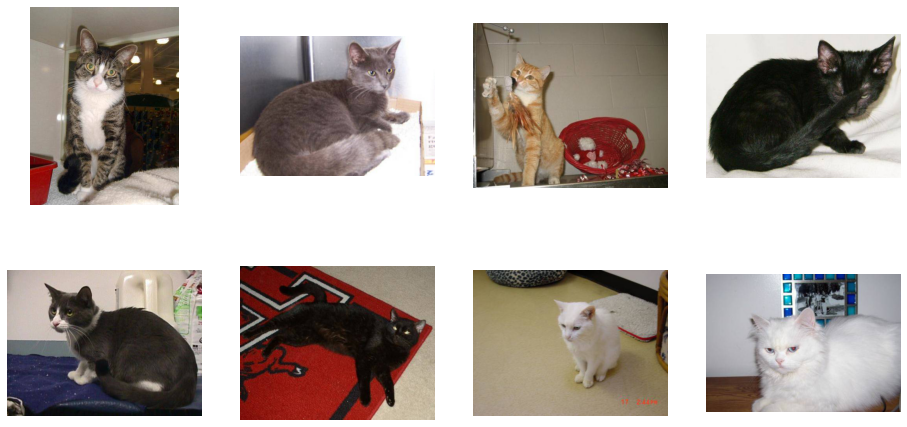

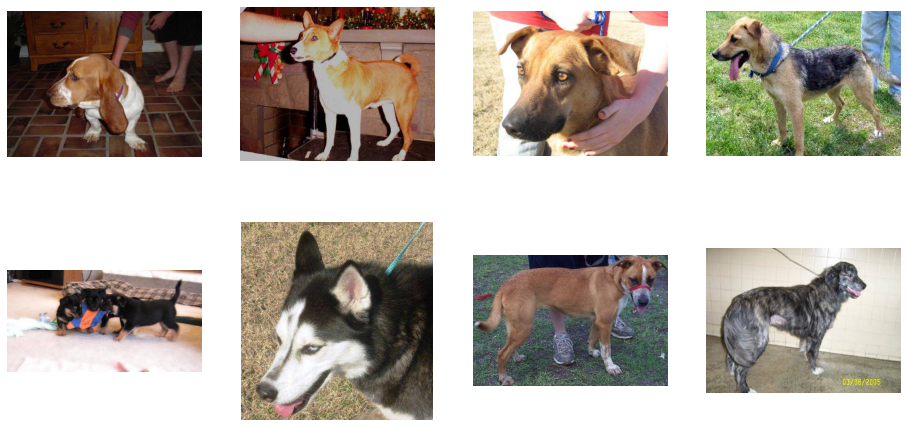

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)

next_cats_pic = train_data_cats[:8]
next_dogs_pic = train_data_dogs[:8]

for i, img_path in enumerate(next_cats_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(train_dir + '/cats/' + img_path)
  plt.imshow(img)
plt.show()

fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 2)

for i, img_path in enumerate(next_dogs_pic):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(2, 4, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(train_dir + '/dogs/' + img_path)
  plt.imshow(img)
plt.show()

# 2. Preprocessing Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# melakukan image augmentation pada dataset untuk menambah variasi data
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   dtype=tf.float32)

test_datagen = ImageDataGenerator( rescale = 1.0/255.,
                                   dtype=tf.float32)

# melakukan data generator untuk membaca dataset training di setiap label
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 32,
                                                    class_mode = 'binary', 
                                                    target_size = (224, 224))     

# # melakukan data generator untuk membaca dataset testing di setiap label
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 32,
                                                          class_mode  = 'binary', 
                                                          target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 3. Modeling

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.utils import plot_model

In [ ]:
#@title Pilih Pretrained Model :  { display-mode: "both" }
Model = "MobileNet" #@param ["VGG16", "MobileNet", "InceptionNet", "ResNet"]

# Pilihan pretrained model yang dapat digunakan di sesi ini
if Model == "VGG16":
  base_model = VGG16(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')
  
elif Model == "ResNet50":
  base_model = ResNet50(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')
  
elif Model == "MobileNet":
  base_model = MobileNet(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet')
  
else:
  base_model = InceptionV3(
    input_shape = (224, 224, 3),
    include_top = False,
    weights = 'imagenet' 
)

print("Anda akan menggunakan model : ", Model)

# membuat base model tidak diikutkan proses training
for layer in base_model.layers:
  layer.trainable = False

Anda akan menggunakan model :  MobileNet


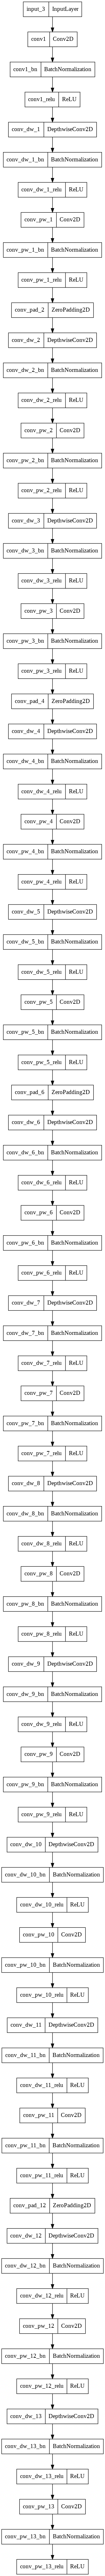

In [ ]:
# membuat visualisasi plot arsetektur yang telah kita pilih
plot_model(base_model, to_file='my_base_model.png')

In [ ]:
# kita juga bisa menggunakan .summary() untuk menampilkan arsitektur kita
base_model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
import tensorflow as tf


x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dense(32, activation='relu')(x)
x = tf.keras.layers.Dropout(0.15)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
history = model.fit(train_generator, validation_data=validation_generator,
                    steps_per_epoch = 60, epochs = 5)

Epoch 1/5
60/60 [==============================] - 44s 532ms/step - loss: 0.6457 - accuracy: 0.6324 - val_loss: 0.5698 - val_accuracy: 0.7200
Epoch 2/5
60/60 [==============================] - 30s 497ms/step - loss: 0.5358 - accuracy: 0.7379 - val_loss: 0.4271 - val_accuracy: 0.8280
Epoch 3/5
60/60 [==============================] - 30s 499ms/step - loss: 0.4394 - accuracy: 0.8114 - val_loss: 0.3419 - val_accuracy: 0.8520
Epoch 4/5
60/60 [==============================] - 31s 510ms/step - loss: 0.3729 - accuracy: 0.8424 - val_loss: 0.2744 - val_accuracy: 0.8900
Epoch 5/5
60/60 [==============================] - 30s 497ms/step - loss: 0.3461 - accuracy: 0.8482 - val_loss: 0.2450 - val_accuracy: 0.9020


# 4. Evaluasi

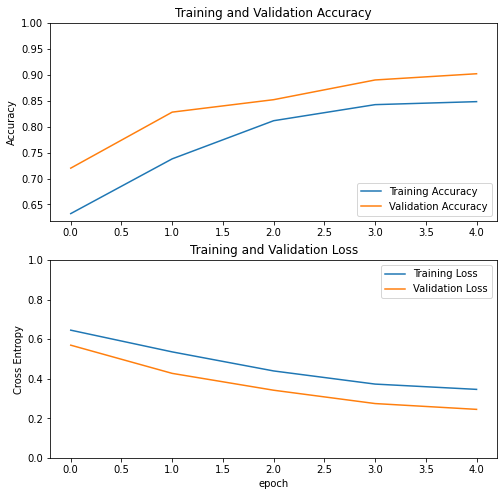

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

32/32 [==============================] - 5s 146ms/step


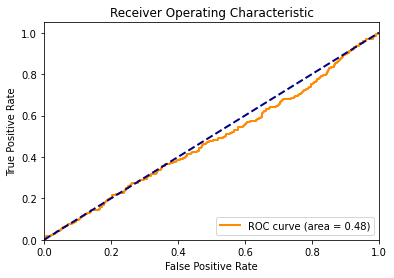

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

preds = model.predict(validation_generator, verbose=1)
fpr, tpr, _ = roc_curve(validation_generator.classes, preds)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# 5. Testing Pada Images

Saving anjing.jpg to anjing.jpg


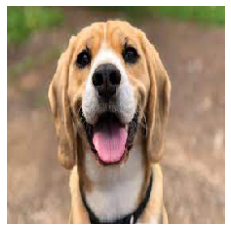


 ini adalah anjing


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  
  plt.imshow(x/255.)
  plt.axis('off')
  plt.show()

  x = np.expand_dims(x, axis=0)
  # images = np.vstack([x])

  classes = model.predict(x)
  
  if classes[0]<0.5:
    print("\n ini adalah kucing")
  else:
    print("\n ini adalah anjing")